In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [63]:
def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    # set up parameters
    N = len(model_list) 
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()
    y_opt_list = [None] * N
    as_nodes_list = [None] * N
    ms_list = [None] * N
    new_nodes_list = [None] * N
    
    # set up solver
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = tolerance
    solver.options['NonConvex'] = 2 

        
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('Iteration starts')
    for k in range(add_node_num+1):
        print('Adding extra node ',k)
        for i in range(N):
            print('Solving scenario ',i)
            # calculate 
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
            # define piecewise function for each scenario
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            if hasattr(model_list[i], 'obj'):
                model_list[i].del_component('obj')

            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound
            
            
            if (k == add_node_num) and (i == 0):
                last_ynode = value(model_list[i].y)
                print('')
                print('PPPPPPPPPPPPP')
                print('new node is ',last_ynode)
                
                


            
            # check if new node is too close to old nodes
            if (k > 0):
                print('哈哈哈哈哈')
                print('last node is ',new_nodes_list[i])
                print('new node is ',value(model_list[i].y))
                print(abs(new_nodes_list[i] - value(model_list[i].y)))
                print('')
                
            if (k > 0) and (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("新点过近，未插入")
                break
            new_nodes_list[i] = value(model_list[i].y)
            if (new_nodes_list[i] not in y_nodes) and (k != add_node_num):
                bisect.insort(y_nodes, new_nodes_list[i])
            #y_opt_list[i] = value(model_list[i].y)
          


    
    # define and solve the sum model
    #print(22)
    #assum_nodes = np.sum(as_nodes_list, axis=0).tolist()
    print('abab',len(y_nodes))
    print('aa',len(as_nodes_list[0]))
    assum_nodes = np.sum(as_nodes_list, axis=0)
    print('bb',len(as_nodes_list[0]))
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    solver.solve(model_sum)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("bad bad bad")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = 0.59187 - errors
    #errors = value(model_sum.obj) + sum(ms_list)
    #errors = -errors
    
    #errors = -ms_list[0]
    delta = (new_ub-new_lb)/2
    
    print('node is ',add_node_num)
    print('error is ',errors)
    print('end')
    print(' ')
    print(' ')
    
    #return delta, errors, 1, 2  # diameter, error
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], last_ynode,as_nodes_list[1], ms_list[1]



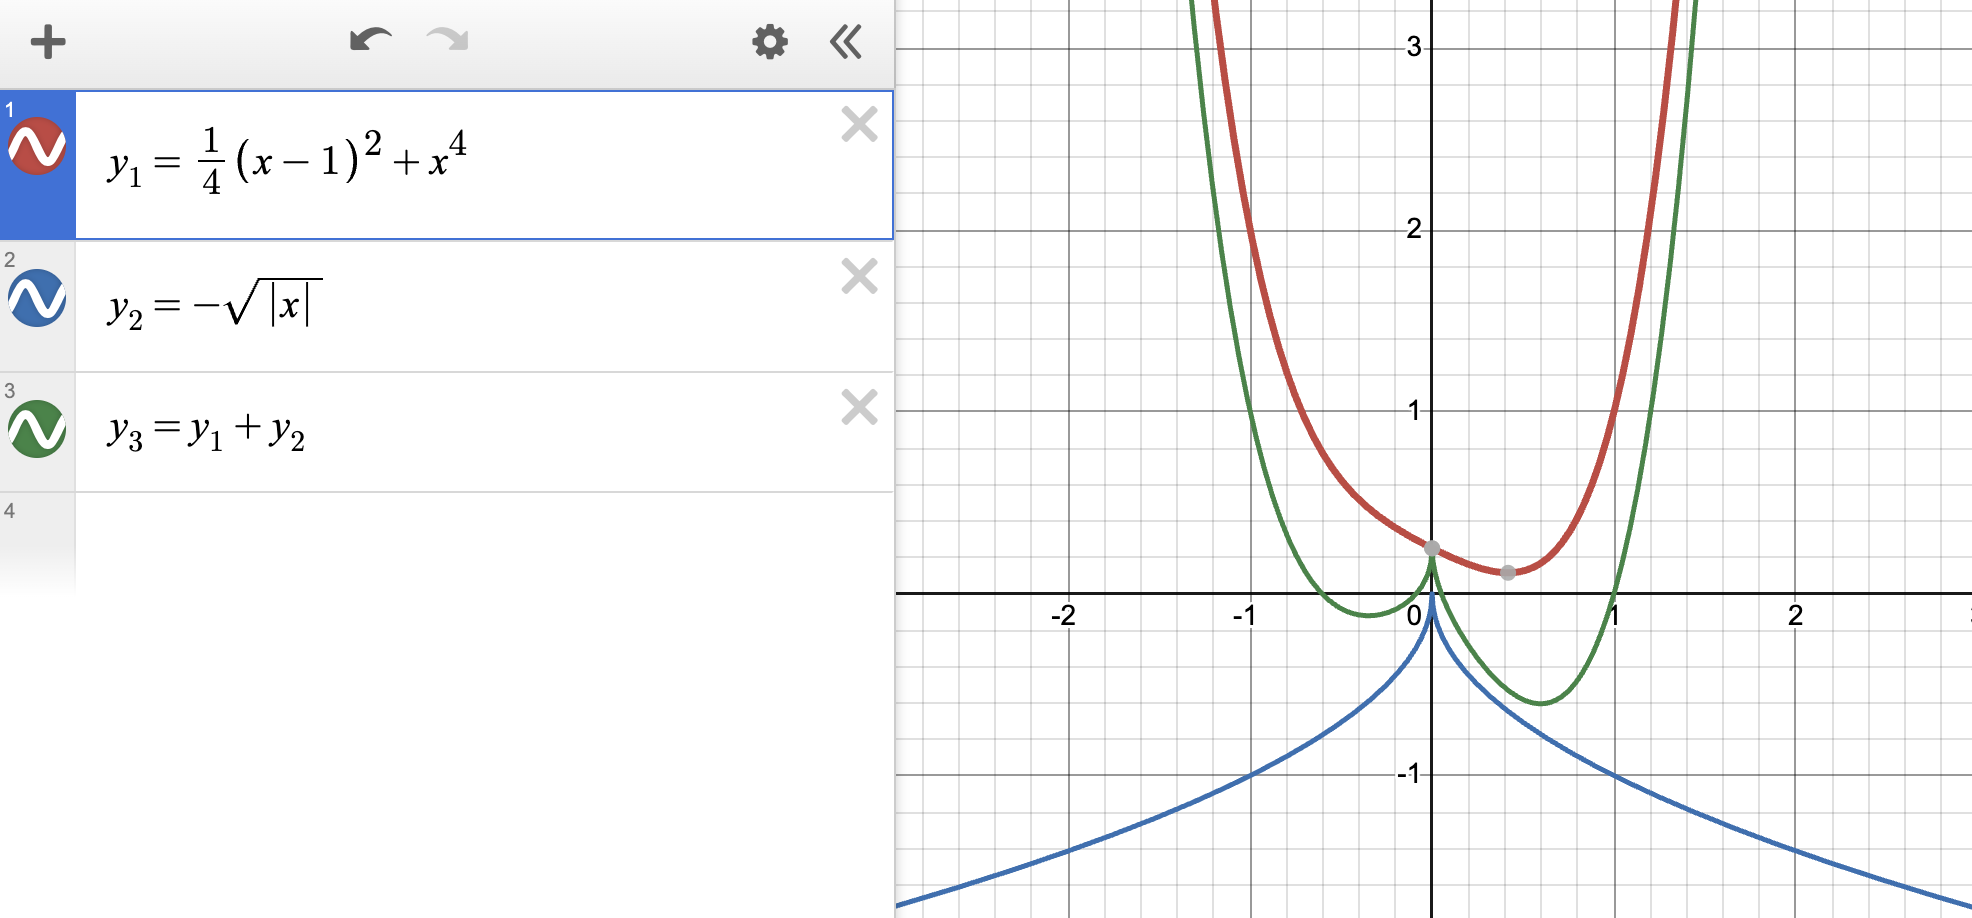

In [64]:
# build function for each scenario
def v_1(y):  
    return (1/4)*(y-1)**2 + y**4

def v_2(y): 
    return - np.sqrt(np.abs(y))

v_list = [v_1, v_2]

ylb = -1
yub = 1

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(-1, 1))
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=(1/4)*(m1.y-1)**2+m1.x1**2)


m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x1 = Var(bounds=(0, 1))
m2.x11 = Var(bounds=(0, None))
m2.c1 = Constraint(expr=m2.x11**2 == m2.y**2)
m2.c2 = Constraint(expr=m2.x11 == (m2.x1)**2)
m2.obj_expr = Expression(expr=-m2.x1)

model_list = [m1, m2]

In [65]:
# make delta list
##deltas = np.array([1, 1e-1, 1e-2,1e-03, 1e-4, 1e-5])
adds = np.arange(0, 10)
results = [nc_underest(ylb,yub,v_list,[m1,m2],a) for a in adds]

start
Adding node  0
Solving scenario  0


python(1135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  -0.7750729744015677
Solving scenario  1
abab 5
aa 5
bb 5


python(1137) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1139) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  0
error is  1.5836211787795382
end
 
 
start
Adding node  0
Solving scenario  0


python(1141) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1143) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1146) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  0.7750681635801425
哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638107
0.24936392648114267

abab 7
aa 7
bb 7


python(1153) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  1
error is  1.5836064980845723
end
 
 
start
Adding node  0
Solving scenario  0


python(1157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1159) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1161) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1163) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  0.892019953582722
哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.031256153043930424
0.15563780766031154

abab 9
aa 9
bb 9


python(1177) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  2
error is  1.3255632651858817
end
 
 
start
Adding node  0
Solving scenario  0


python(1181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.0311595099017154
0.15554116451809652

Adding node  3
Solving scenario  0


python(1197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  -0.8920223086119757
哈哈哈哈哈
last node is  0.892019953582722
new node is  -0.8920223086119757
1.7840422621946979

Solving scenario  1
哈哈哈哈哈
last node is  -0.0311595099017154
new node is  0.031116550183265205
0.0622760600849806

abab 11
aa 11
bb 11


python(1203) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1205) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  3
error is  1.3253481223861976
end
 
 
start
Adding node  0
Solving scenario  0


python(1207) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.0311595099017154
0.15554116451809652

Adding node  3
Solving scenario  0


python(1228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.892019953582722
new node is  -0.8920223086119757
1.7840422621946979

Solving scenario  1
哈哈哈哈哈
last node is  -0.0311595099017154
new node is  0.030969700249584887
0.06212921015130028

Adding node  4
Solving scenario  0


python(1232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  -0.646421740020285
哈哈哈哈哈
last node is  -0.8920223086119757
new node is  -0.646421740020285
0.24560056859169077

Solving scenario  1
哈哈哈哈哈
last node is  0.030969700249584887
new node is  -0.007817684651777426
0.03878738490136231

abab 13
aa 13
bb 13


python(1239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  4
error is  1.26954241606242
end
 
 
start
Adding node  0
Solving scenario  0


python(1245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.0311595099017154
0.15554116451809652

Adding node  3
Solving scenario  0


python(1257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.892019953582722
new node is  -0.8920223086119757
1.7840422621946979

Solving scenario  1
哈哈哈哈哈
last node is  -0.0311595099017154
new node is  0.030969700249584887
0.06212921015130028

Adding node  4
Solving scenario  0


python(1261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.8920223086119757
new node is  -0.646421740020285
0.24560056859169077

Solving scenario  1
哈哈哈哈哈
last node is  0.030969700249584887
new node is  -0.007725914198397538
0.038695614447982425

Adding node  5
Solving scenario  0


python(1265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  0.6464190748710321
哈哈哈哈哈
last node is  -0.646421740020285
new node is  0.6464190748710321
1.292840814891317

Solving scenario  1
哈哈哈哈哈
last node is  -0.007725914198397538
new node is  0.007725072522214654
0.015450986720612191

abab 15
aa 15
bb 15


python(1269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  5
error is  1.26940852322701
end
 
 
start
Adding node  0
Solving scenario  0


python(1273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.0311595099017154
0.15554116451809652

Adding node  3
Solving scenario  0


python(1285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.892019953582722
new node is  -0.8920223086119757
1.7840422621946979

Solving scenario  1
哈哈哈哈哈
last node is  -0.0311595099017154
new node is  0.030969700249584887
0.06212921015130028

Adding node  4
Solving scenario  0


python(1289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.8920223086119757
new node is  -0.646421740020285
0.24560056859169077

Solving scenario  1
哈哈哈哈哈
last node is  0.030969700249584887
new node is  -0.007725914198397538
0.038695614447982425

Adding node  5
Solving scenario  0


python(1294) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1296) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.646421740020285
new node is  0.6464190748710321
1.292840814891317

Solving scenario  1
哈哈哈哈哈
last node is  -0.007725914198397538
new node is  0.007749465407532481
0.015475379605930019

Adding node  6
Solving scenario  0


python(1298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  0.33715822030058
哈哈哈哈哈
last node is  0.6464190748710321
new node is  0.33715822030058
0.3092608545704521

Solving scenario  1
哈哈哈哈哈
last node is  0.007749465407532481
new node is  0.28079548797428416
0.2730460225667517

abab 17
aa 17
bb 17


python(1303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1305) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  6
error is  1.2508946755263635
end
 
 
start
Adding node  0
Solving scenario  0


python(1307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.0311595099017154
0.15554116451809652

Adding node  3
Solving scenario  0


python(1319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1321) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.892019953582722
new node is  -0.8920223086119757
1.7840422621946979

Solving scenario  1
哈哈哈哈哈
last node is  -0.0311595099017154
new node is  0.030969700249584887
0.06212921015130028

Adding node  4
Solving scenario  0


python(1323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1325) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.8920223086119757
new node is  -0.646421740020285
0.24560056859169077

Solving scenario  1
哈哈哈哈哈
last node is  0.030969700249584887
new node is  -0.007725914198397538
0.038695614447982425

Adding node  5
Solving scenario  0


python(1329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1331) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.646421740020285
new node is  0.6464190748710321
1.292840814891317

Solving scenario  1
哈哈哈哈哈
last node is  -0.007725914198397538
new node is  0.007749465407532481
0.015475379605930019

Adding node  6
Solving scenario  0


python(1333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.6464190748710321
new node is  0.33715822030058
0.3092608545704521

Solving scenario  1
哈哈哈哈哈
last node is  0.007749465407532481
new node is  -0.28122494198063724
0.2889744073881697

Adding node  7
Solving scenario  0


python(1337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  0.9469891804057962
哈哈哈哈哈
last node is  0.33715822030058
new node is  0.9469891804057962
0.6098309601052161

Solving scenario  1
哈哈哈哈哈
last node is  -0.28122494198063724
new node is  0.0019389208238284178
0.28316386280446565

abab 19
aa 19
bb 19


python(1342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  7
error is  1.2284170812031667
end
 
 
start
Adding node  0
Solving scenario  0


python(1347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1350) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.0311595099017154
0.15554116451809652

Adding node  3
Solving scenario  0


python(1360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.892019953582722
new node is  -0.8920223086119757
1.7840422621946979

Solving scenario  1
哈哈哈哈哈
last node is  -0.0311595099017154
new node is  0.030969700249584887
0.06212921015130028

Adding node  4
Solving scenario  0


python(1365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.8920223086119757
new node is  -0.646421740020285
0.24560056859169077

Solving scenario  1
哈哈哈哈哈
last node is  0.030969700249584887
new node is  -0.007725914198397538
0.038695614447982425

Adding node  5
Solving scenario  0


python(1370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.646421740020285
new node is  0.6464190748710321
1.292840814891317

Solving scenario  1
哈哈哈哈哈
last node is  -0.007725914198397538
new node is  0.007749465407532481
0.015475379605930019

Adding node  6
Solving scenario  0


python(1374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.6464190748710321
new node is  0.33715822030058
0.3092608545704521

Solving scenario  1
哈哈哈哈哈
last node is  0.007749465407532481
new node is  -0.28122494198063724
0.2889744073881697

Adding node  7
Solving scenario  0


python(1378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.33715822030058
new node is  0.9469891804057962
0.6098309601052161

Solving scenario  1
哈哈哈哈哈
last node is  -0.28122494198063724
new node is  0.0019279213736212524
0.2831528633542585

Adding node  8
Solving scenario  0


python(1382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  -0.9469986513832316
哈哈哈哈哈
last node is  0.9469891804057962
new node is  -0.9469986513832316
1.8939878317890277

Solving scenario  1
哈哈哈哈哈
last node is  0.0019279213736212524
new node is  -0.0019227347915552748
0.003850656165176527

abab 21
aa 21
bb 21


python(1386) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  8
error is  1.2283844865868119
end
 
 
start
Adding node  0
Solving scenario  0


python(1392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving scenario  1
Adding node  1
Solving scenario  0


python(1396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.7750729744015677
new node is  0.7750681635801425
1.5501411379817103

Solving scenario  1
哈哈哈哈哈
last node is  -0.1249822718647616
new node is  0.12438165461638111
0.2493639264811427

Adding node  2
Solving scenario  0


python(1402) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.7750681635801425
new node is  0.892019953582722
0.11695179000257949

Solving scenario  1
哈哈哈哈哈
last node is  0.12438165461638111
new node is  -0.0311595099017154
0.15554116451809652

Adding node  3
Solving scenario  0


python(1406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.892019953582722
new node is  -0.8920223086119757
1.7840422621946979

Solving scenario  1
哈哈哈哈哈
last node is  -0.0311595099017154
new node is  0.030969700249584887
0.06212921015130028

Adding node  4
Solving scenario  0


python(1410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.8920223086119757
new node is  -0.646421740020285
0.24560056859169077

Solving scenario  1
哈哈哈哈哈
last node is  0.030969700249584887
new node is  -0.007725914198397538
0.038695614447982425

Adding node  5
Solving scenario  0


python(1414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.646421740020285
new node is  0.6464190748710321
1.292840814891317

Solving scenario  1
哈哈哈哈哈
last node is  -0.007725914198397538
new node is  0.007749465407532481
0.015475379605930019

Adding node  6
Solving scenario  0


python(1418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.6464190748710321
new node is  0.33715822030058
0.3092608545704521

Solving scenario  1
哈哈哈哈哈
last node is  0.007749465407532481
new node is  -0.28122494198063724
0.2889744073881697

Adding node  7
Solving scenario  0


python(1422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.33715822030058
new node is  0.9469891804057962
0.6098309601052161

Solving scenario  1
哈哈哈哈哈
last node is  -0.28122494198063724
new node is  0.0019279213736212524
0.2831528633542585

Adding node  8
Solving scenario  0


python(1426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  0.9469891804057962
new node is  -0.9469986513832316
1.8939878317890277

Solving scenario  1
哈哈哈哈哈
last node is  0.0019279213736212524
new node is  -0.0019179983179678317
0.0038459196915890843

Adding node  9
Solving scenario  0


python(1430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PPPPPPPPPPPPP
new node is  0.8348348218172442
哈哈哈哈哈
last node is  -0.9469986513832316
new node is  0.8348348218172442
1.781833473200476

Solving scenario  1


python(1434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


哈哈哈哈哈
last node is  -0.0019179983179678317
new node is  -0.07023740540313969
0.06831940708517185

abab 23
aa 23
bb 23


python(1436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


node is  9
error is  1.21991978415006
end
 
 


   
   
   
add num  0
y node is  [-1.  -0.5  0.   0.5  1. ]
y node length 5
as_nodes is  [2.0, 0.625, 0.25, 0.125, 1.0]
yas_nodes length 5
ms value is  -0.23285361089048928
y_opt value is  -0.7750729744015677
   
   
   
add num  1
y node is  [-1.         -0.77507297 -0.5        -0.12498227  0.          0.5
  1.        ]
y node length 7
as_nodes is  [2.0, 0.625, 0.25, 0.125, 1.0]
yas_nodes length 5
ms value is  -0.23285247118236618
y_opt value is  0.7750681635801425
   
   
   
add num  2
y node is  [-1.         -0.77507297 -0.5        -0.12498227  0.          0.12438165
  0.5         0.77506816  1.        ]
y node length 9
as_nodes is  [2.0, 0.625, 0.25, 0.125, 1.0]
yas_nodes length 5
ms value is  -0.06320415615468894
y_opt value is  0.892019953582722
   
   
   
add num  3
y node is  [-1.         -0.77507297 -0.5        -0.12498227 -0.03115951  0.
  0.12438165  0.5         0.77506816  0.89201995  1.        ]
y node length 11
as_nodes is  [2.0, 0.625, 0.25, 0.125, 1.0]
yas_nodes leng

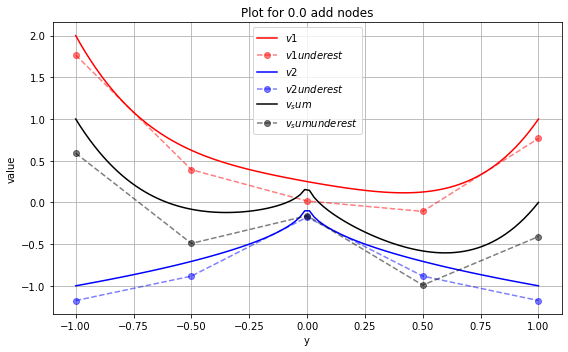

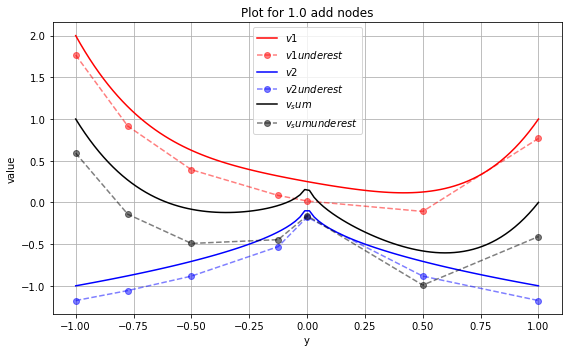

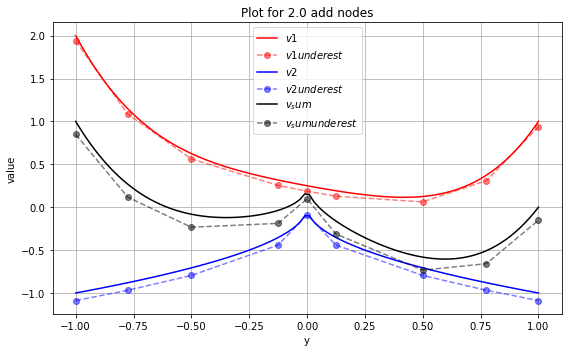

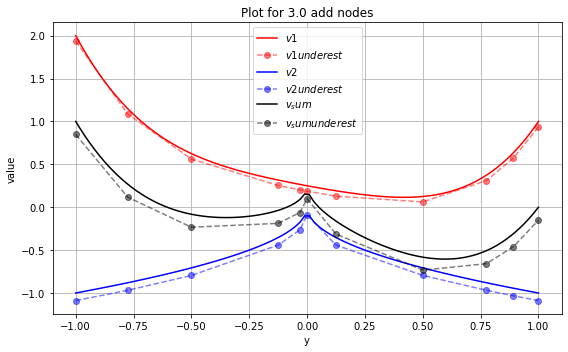

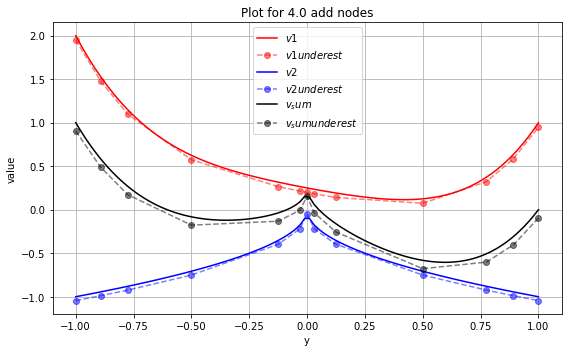

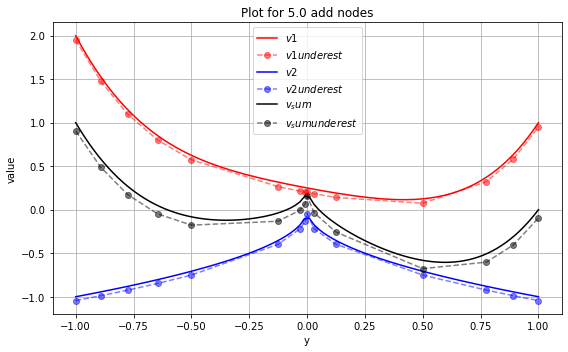

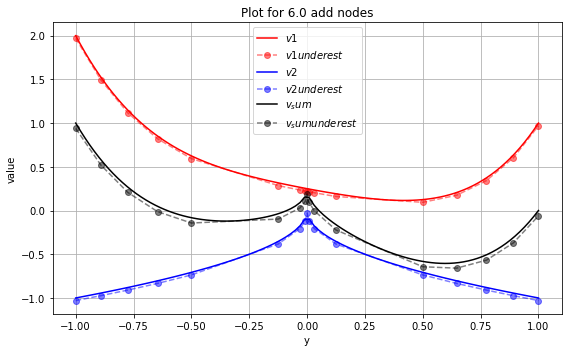

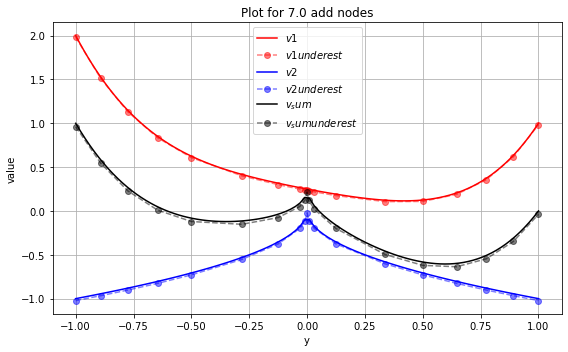

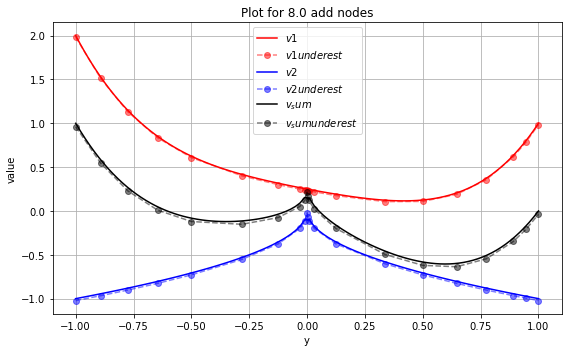

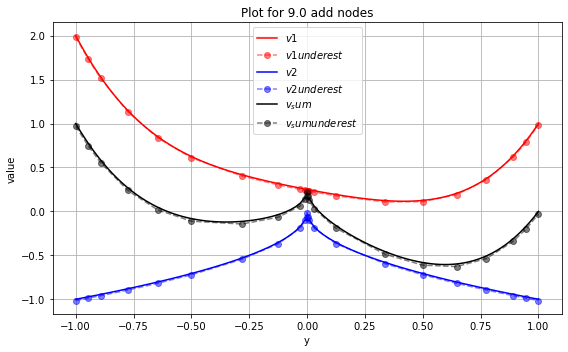

In [66]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][-2])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][-1]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('add num ',i)
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print('as_nodes is ',as_nodes)
    print('yas_nodes length',len(as_nodes))
    print("ms value is ",results[i][4])
    print("y_opt value is ",results[i][5])

    # make the plot
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    
    plt.xlabel('y')
    plt.ylabel('value')
    #plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    



plt.show()

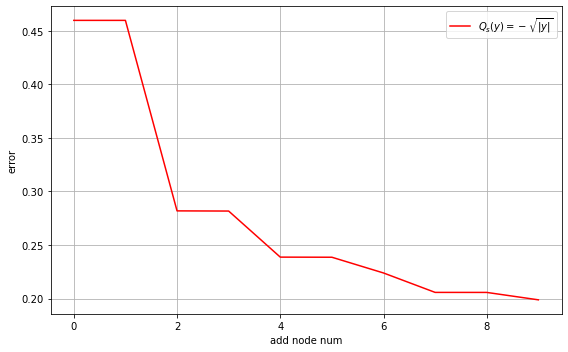

In [67]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, np.log(errors), label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')

plt.xlabel('add node num')
plt.ylabel('error')
#plt.title(f"Plot for {0:.1f} add nodes")
plt.legend()
plt.grid(True)
#plt.xlim(-0.2, 0.2)  
#plt.ylim(-0.5, 0)  

plt.tight_layout()